In [1]:
from scipy import signal as sig

# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import multilayer_perceptron_library as network_lib

import autograd.numpy as np
from autograd import grad as compute_grad   

import autograd.numpy as np
import numpy as npo

import pandas as pd
import cv2
import csv
import pickle
import glob
import time
import copy
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# fixed convolution feature extractor

Load in test bank of kernels.

In [2]:
# copy over test kernels
new_kernels = []
kernels = convlib.image_viz.load_kernels()
for ind, kernel in kernels.items():
    new_kernels.append(kernel)
new_kernels = np.asarray(new_kernels)
kernels = copy.deepcopy(new_kernels)

Load in data.

In [3]:
demo = network_lib.network_learner.Network()

# load in dataset
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')

Fixed conv transform.

In [14]:
# sliding window for image augmentation
def sliding_window_tensor(tensor, kernel, stride):
    windowed_tensor = []
    for i in np.arange(0, np.shape(tensor)[1]-kernel.shape[0]+1, stride):
        for j in np.arange(0, np.shape(tensor)[2]-kernel.shape[1]+1, stride):
            sock = copy.deepcopy(tensor[:,i:i+kernel.shape[0], j:j+kernel.shape[1]])
            windowed_tensor.append(sock)
    
    # re-shape properly
    windowed_tensor = np.asarray(windowed_tensor)
    windowed_tensor = windowed_tensor.swapaxes(0,1)
    windowed_tensor = windowed_tensor.reshape(np.shape(windowed_tensor)[0]*np.shape(windowed_tensor)[1],np.shape(windowed_tensor)[2]*np.shape(windowed_tensor)[3])    
    return windowed_tensor

# pad image with appropriate number of zeros for convolution
def pad_tensor(tensor,kernel):
    odd_nums = np.asarray([int(2*n + 1) for n in range(100)])
    val = kernel.shape[0]
    pad_val = np.argwhere(odd_nums == val)[0][0]
    tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
    tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
    return tensor_padded    

# activation 
def activation(t):
    return np.maximum(0,t)

# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/(data_std + 10**(-5))
    return normalized_data

def conv_layer(tensor,kernels):
    # square up tensor into tensor of patches
    tensor = tensor.reshape(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5)),order = 'F')

    # pad tensor
    kernel = kernels[0]
    padded_tensor = pad_tensor(tensor,kernel)

    # window tensor
    wind_tensor = sliding_window_tensor(padded_tensor,kernel,stride = 1)

    # normalize windows since they touch weights
    a_means = np.mean(wind_tensor,axis = 0)
    a_stds = np.std(wind_tensor,axis = 0)
    wind_tensor = normalize(wind_tensor,a_means,a_stds)
    
    #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
    kernel2 = np.ones((6,6))
    stride = 3
    new_tensors = []
    for kernel in kernels:
        #### make convolution feature map - via matrix multiplication over windowed tensor 
        feature_map = np.dot(wind_tensor,kernel.flatten()[:,np.newaxis])

        # reshape convolution feature map into array
        np.reshape(feature_map,np.shape(tensor))

        # now shove result through nonlinear activation
        feature_map = activation(feature_map)

        #### now pool / downsample feature map, first window then pool on each window
        wind_featmap = sliding_window_tensor(feature_map,kernel2,stride = stride)

        # max pool on each collected patch
        max_pool = np.max(wind_featmap,axis = 1)

        # reshape into new tensor
        max_pool.shape = (np.shape(tensor)[0],int((np.shape(max_pool)[0]/float(np.shape(tensor)[0]))**(0.5)),int((np.shape(max_pool)[0]/float(np.shape(tensor)[0]))**(0.5)))

        # reshape into new downsampled pooled feature map
        new_tensors.append(max_pool)

    # turn into array
    new_tensors = np.asarray(new_tensors)

    # reshape into final feature vector to touch fully connected layer(s), otherwise keep as is in terms of shape
    new_tensors = new_tensors.swapaxes(0,1)
    new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1],np.shape(new_tensors)[2]*np.shape(new_tensors)[3]))
    new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1]*np.shape(new_tensors)[2]),order = 'F')

    return new_tensors

Transform all input data.

In [5]:
# extract input tensor
tensor = data[:,:-1]
y = data[:,-1:]

# contrast normalize image data
def contrast_normalize(data):
    data_means = np.mean(data,axis = 0)
    data = data - data_means
    data_stds = np.std(data,axis = 0)
    data = data/data_stds
    return data

# contrast normalize the input 
tensor_decontrast = contrast_normalize(tensor.T).T

# run through conv layer with fixed kernels
new_tensor = conv_layer(tensor_decontrast,kernels)

# make new data based on fixed kernel convolutions
data = np.concatenate((tensor_decontrast,y),axis = 1)
new_data = np.concatenate((new_tensor,y),axis = 1)

## Raw pixels

In [6]:
# load in data - for this one split up training and testing
ind = np.random.permutation(len(data))

# split it up
data_train = data[ind[:-2000],:]
data_test = data[ind[-2000:],:]
demo.input_data(data_train,data_test,normalize = True)

In [7]:
# choose cost function
demo.choose_cost(cost_name = 'twoclass_softmax')

# setup network architecture
activation_name = 'relu'
layer_sizes = [np.shape(data_train)[1]-1,10,1]
demo.architecture_settings(activation_name,layer_sizes)

# setup optimizer
demo.optimizer_settings(alpha = 10**(-1),max_its = 100,version = 'normalized',scale = 0.1)

# fit
demo.fit(verbose = True)

In [8]:
# compute cost plots on training and testing data
demo.compute_cost_plots()

# compute lowest testing misclassifications
ind_min = np.argmin(demo.test_count_history)
test_min = demo.test_count_history[ind_min]
train_min = demo.train_count_history[ind_min]
print ('test misclassifications = ' + str(int(test_min)))
print ('train misclassifications = ' + str(int(train_min)))

test misclassifications = 75
train misclassifications = 167


<IPython.core.display.Javascript object>


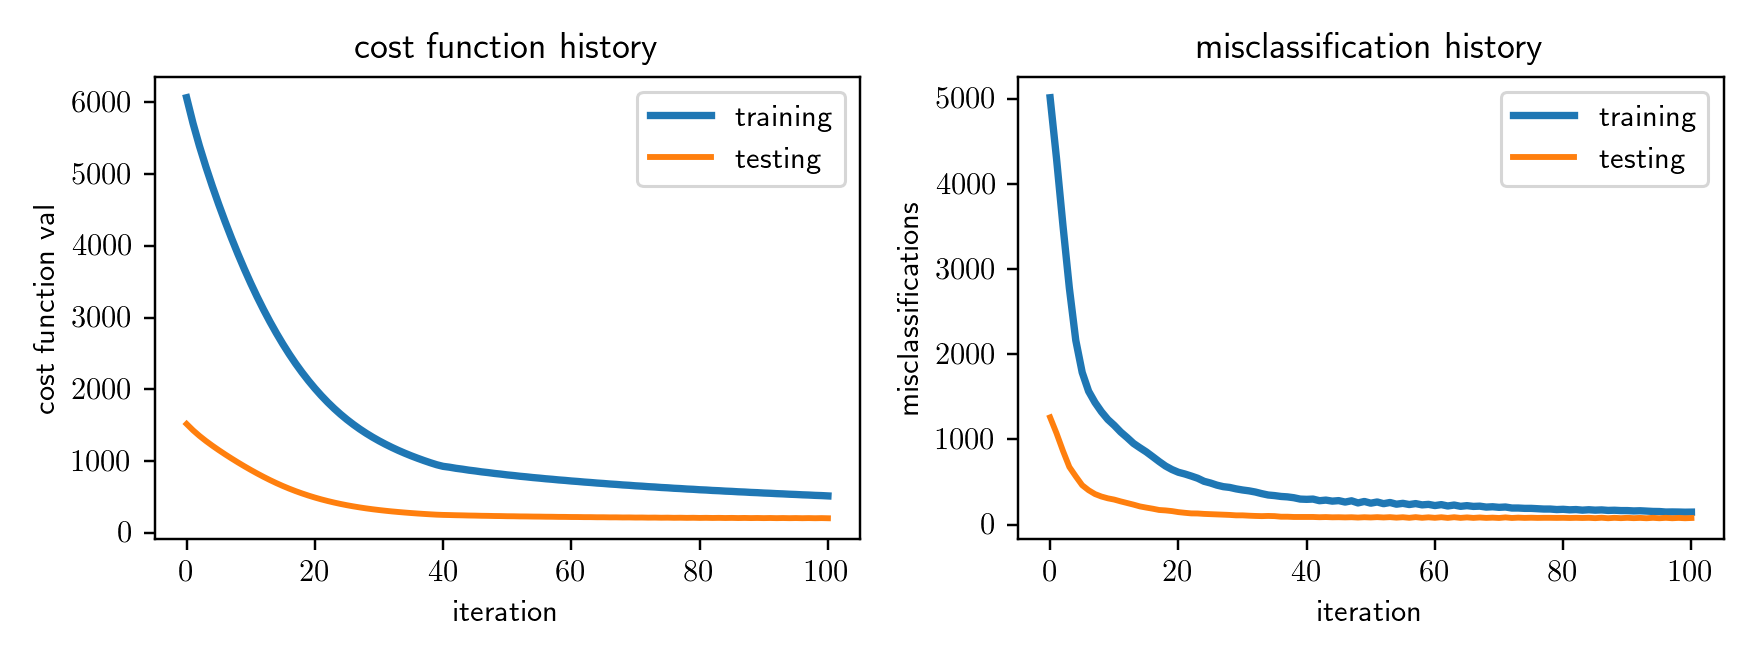

In [9]:
# produce cost functio plots for training and testing data
demo.plot_histories(start = 0)

## fixed convolution features

In [10]:
# split it up
data_train = new_data[ind[:-2000],:]
data_test = new_data[ind[-2000:],:]
demo.input_data(data_train,data_test,normalize = True)

In [15]:
# choose cost function
demo.choose_cost(cost_name = 'twoclass_softmax')

# setup network architecture
activation_name = 'relu'
layer_sizes = [np.shape(data_train)[1]-1,10,1]
demo.architecture_settings(activation_name,layer_sizes)

# setup optimizer
demo.optimizer_settings(alpha = 10**(-1),max_its = 200,version = 'normalized',scale = 0.1)

# fit
demo.fit(verbose = True)

In [16]:
# compute cost plots on training and testing data
demo.compute_cost_plots()

# compute lowest testing misclassifications
ind_min = np.argmin(demo.test_count_history)
test_min = demo.test_count_history[ind_min]
train_min = demo.train_count_history[ind_min]
print ('test misclassifications = ' + str(int(test_min)))
print ('train misclassifications = ' + str(int(train_min)))

test misclassifications = 21
train misclassifications = 11


<IPython.core.display.Javascript object>


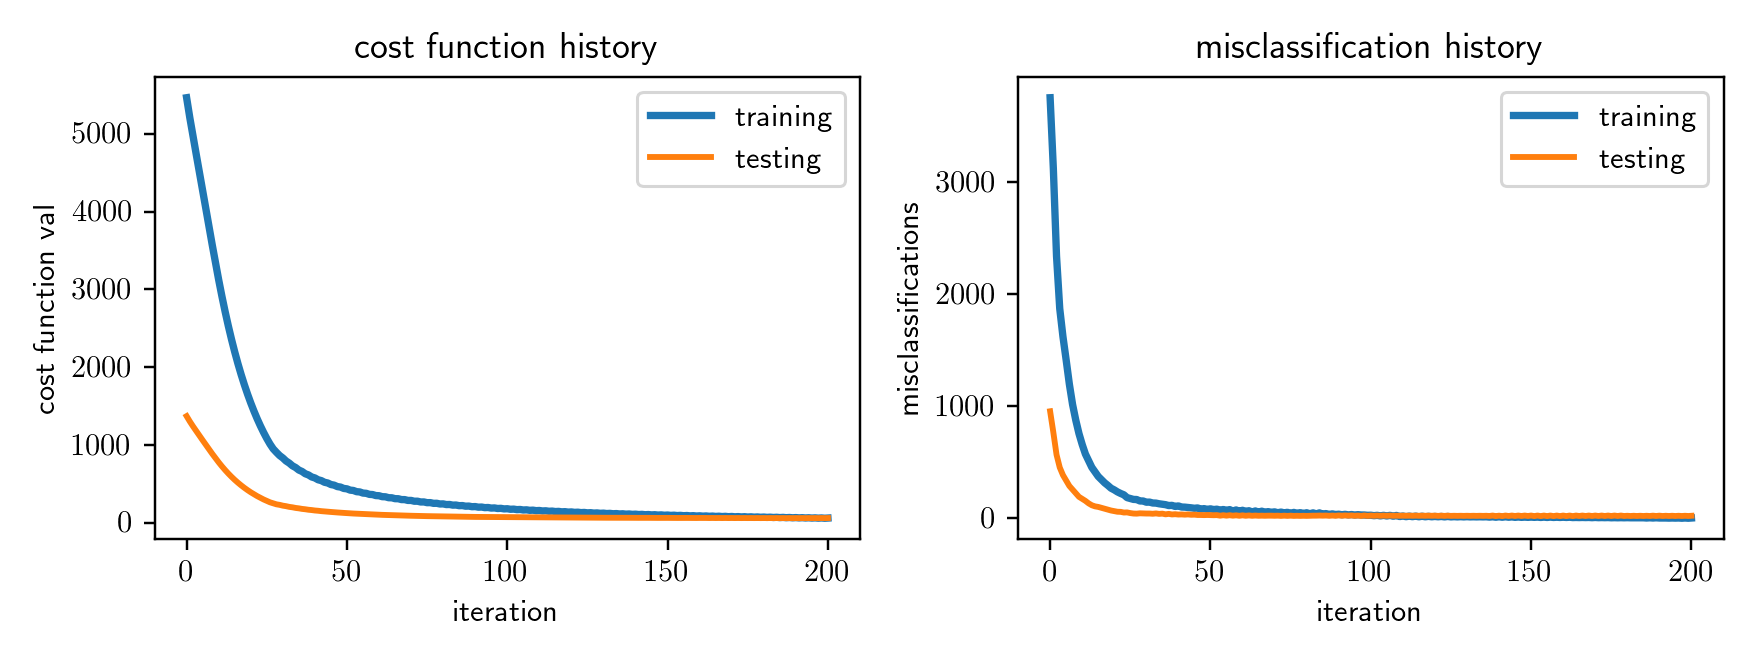

In [17]:
# produce cost functio plots for training and testing data
demo.plot_histories(start = 0)